In [1]:
#check cuda version 
!nvcc --version 
# install pytorch according to the cuda version from the pytorch website
!pip install torch==1.7.0+cu101 torchvision==0.8.1+cu101 torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html
# install mmcv
!pip install mmcv-full==1.1.4
#clone github repository
!git clone https://github.com/rubeea/focal_phi_loss_mmsegmentation.git 
#install all requirements
!pip install -qr focal_phi_loss_mmsegmentation/requirements.txt 
%cd /content/focal_phi_loss_mmsegmentation
#install mmsegmentation in develop mode
!python setup.py develop 

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 735.3 MB 24 kB/s 
     |████████████████████████████████| 12.7 MB 37.0 MB/s 
     |████████████████████████████████| 7.6 MB 23.6 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.12.0+cu113
    Uninstalling torch-1.12.0+cu113:
      Successfully uninstalled torch-1.12.0+cu113
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.13.0+cu113
    Uninstalling torchvision-0.13.0+cu113:
      Successfully uninstalled torchvision-0.13.0+cu113
  Attempting uninstall: torchaudio
    Found existing installation: torchaudio 0.12.0+cu113


# Make data directories and upload the data in them

In [6]:
#declare global variables
root_dir= '/content/focal_phi_loss_mmsegmentation/data/'
data_root= "/content/drive/MyDrive/Colab_Dataset/"
dataset= "ground_truth4_renksiz_oneClass"
#dataset= "mendeley"

In [7]:
import os

#script to extract data from zip files and create the directory structure for mendeley
#!python /content/focal_phi_loss_mmsegmentation/tools/convert_datasets/mendeley.py /content/focal_phi_loss_mmsegmentation/dataset_files/mendeley/train_imgs.zip /content/focal_phi_loss_mmsegmentation/dataset_files/mendeley/train_gt.zip /content/focal_phi_loss_mmsegmentation/dataset_files/mendeley/val_imgs.zip /content/focal_phi_loss_mmsegmentation/dataset_files/mendeley/val_gt.zip 

#check file counts
train_imgs= data_root + dataset+'/img_dir/train'
val_imgs= data_root + dataset +'/img_dir/val'
train_gt= data_root + dataset+'/ann_dir/train'
val_gt= data_root + dataset+'/ann_dir/val'

#print the file count
print(len(os.listdir(train_imgs)))
print(len(os.listdir(val_imgs)))
print(len(os.listdir(train_gt)))
print(len(os.listdir(val_gt)))

7
3
7
3


#Visualize training and mask images


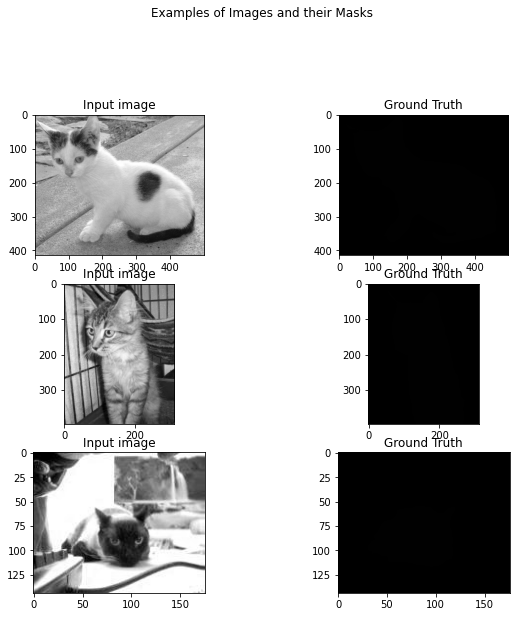

In [8]:
import mmcv
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import numpy as np
import os
import glob


PATH_TO_TRAIN_IMAGES_DIR= data_root+dataset+"/img_dir/train"
PATH_TO_LABEL_IMAGES_DIR= data_root+dataset+"/ann_dir/train"
TRAIN_IMAGE_PATHS = glob.glob(os.path.join(PATH_TO_TRAIN_IMAGES_DIR, "*.jpg"))
LABEL_PATHS= glob.glob(os.path.join(PATH_TO_LABEL_IMAGES_DIR, "*.png"))

TRAIN_IMAGE_PATHS.sort()
LABEL_PATHS.sort()

palette = [[120, 120, 120], [6, 230, 230]] #dataset palette

display_num = 5
r_choices = np.random.choice(len(TRAIN_IMAGE_PATHS), display_num)

#visualize any 5 random images and their mask images
plt.figure(figsize=(10, 15))
for i in range(0, display_num, 2):
  img_num = r_choices[i // 2]
  img = mmcv.imread(TRAIN_IMAGE_PATHS[img_num])
  label = mmcv.imread(LABEL_PATHS[img_num])

  plt.subplot(display_num, 2, i + 1)
  plt.imshow(img)
  plt.title("Input image")

  plt.subplot(display_num, 2, i + 2)
  plt.imshow(label)
  plt.title("Ground Truth")


plt.suptitle("Examples of Images and their Masks")
plt.show()

#Create a config file


In [9]:
#config for ACU-Net
from mmcv import Config
cfg = Config.fromfile('/content/focal_phi_loss_mmsegmentation/configs/unet/fcn_vanilla_unet_s5-d16_256x256_40k_hrf.py')

In [10]:
from mmseg.apis import set_random_seed
import torch

cfg_data_root = data_root+dataset
train_img_dir = 'img_dir/train'
train_ann_dir = 'ann_dir/train'
val_img_dir = 'img_dir/val'
val_ann_dir = 'ann_dir/val'

# Since we use ony one GPU, BN is used instead of SyncBN
cfg.norm_cfg = dict(type='BN', requires_grad=True)
cfg.model.backbone.norm_cfg = cfg.norm_cfg

cfg.model.decode_head.norm_cfg = cfg.norm_cfg

# modify num classes of the model in decode head
cfg.model.decode_head.num_classes = 2

# Modify dataset type and path
cfg.dataset_type = 'MendeleyDataset'
cfg.data_root = cfg_data_root

#batch size
cfg.data.samples_per_gpu = 2
cfg.data.workers_per_gpu=2


#Balanced CE loss
#assign class weights to tackle the imbalanced nature of the dataset in balanced CE loss
# weights = [0.02, 0.98]
# cfg.model.decode_head.loss_decode=dict(type='CrossEntropyLoss', use_sigmoid=False, 
#                                             loss_weight=1.0, class_weight= weights)

#Dice Loss
# cfg.model.decode_head.loss_decode=dict(type='TverskyLoss',  alpha=0.5, beta=0.5, gamma=1.0, use_focal=False, loss_weight=1.0)

#Tversky Loss
# cfg.model.decode_head.loss_decode=dict(type='TverskyLoss',  alpha=0.3, beta=0.7, gamma=1.0, use_focal=False, loss_weight=1.0)

#Focal Tversky Loss
# cfg.model.decode_head.loss_decode=dict(type='TverskyLoss',  alpha=0.3, beta=0.7, gamma=0.75, use_focal=True, loss_weight=1.0)

#MCC loss
# cfg.model.decode_head.loss_decode=dict(type='PhiLoss', loss_weight=1.0, gamma=1.0)

#Focal Phi Loss
cfg.model.decode_head.loss_decode=dict(type='PhiLoss', loss_weight=1.0, gamma=0.5)

#normalizing the dataset
cfg.img_norm_cfg = dict(
    mean= [142.393, 137.978, 83.073], std= [23.228, 20.046, 21.623], to_rgb=True) #for mendeley dataset

cfg.crop_size = (256, 256)

#dataset config
cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(type='Resize', img_scale=(512, 512), ratio_range=(0.5, 1.5)), #for mendeley dataset
    dict(type='RandomRotate', prob=0.5, degree=(45.0,315.0),pad_val=0,seg_pad_val=255), #for pldu and mendeley dataset
    dict(type='RandomCrop', crop_size=cfg.crop_size, cat_max_ratio=0.75),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(type='PhotoMetricDistortion'),
    dict(type='Normalize', **cfg.img_norm_cfg),
    dict(type='Pad', size=cfg.crop_size, pad_val=0, seg_pad_val=255),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_semantic_seg']),
]

cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale= (512, 512), #for mendeley dataset
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            dict(type='RandomFlip'),
            dict(type='Normalize', **cfg.img_norm_cfg),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img']),
        ])
]


cfg.data.train.type = cfg.dataset_type
cfg.data.train.data_root = cfg.data_root
cfg.data.train.img_dir = train_img_dir
cfg.data.train.ann_dir = train_ann_dir
cfg.data.train.pipeline = cfg.train_pipeline
cfg.data.train.split = None

cfg.data.val.type = cfg.dataset_type
cfg.data.val.data_root = cfg.data_root
cfg.data.val.img_dir = val_img_dir
cfg.data.val.ann_dir = val_ann_dir
cfg.data.val.pipeline = cfg.test_pipeline
cfg.data.val.split = None

cfg.data.test.type = cfg.dataset_type
cfg.data.test.data_root = cfg.data_root
cfg.data.test.img_dir = val_img_dir
cfg.data.test.ann_dir = val_ann_dir
cfg.data.test.pipeline = cfg.test_pipeline
cfg.data.test.split = None


# Set up working dir to save files and logs.
cfg.work_dir = root_dir+'/work_dirs/tutorial'

cfg.total_iters = 160
cfg.log_config.interval = 50
cfg.evaluation.interval = 200 #validation at every 200 iterations
cfg.checkpoint_config.interval = 200

# Set seed to facilitate reproducing the result
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

#for Dice Loss, Tversky Loss and Focal Tversky Loss on Mendeley dataset use the following learning rates with Adam:
# lr = 5e-5

cfg.optimizer = dict(type='Adam', lr=1e-3, weight_decay=0.0001,
                     paramwise_cfg = dict(
                        custom_keys={
                            'head': dict(lr_mult=10.)
                        }
                        ))


# Let's have a look at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

/usr/local/lib/python3.7/dist-packages/mmcv/utils/registry.py:64: UserWarning: The old API of register_module(module, force=False) is deprecated and will be removed, please use the new API register_module(name=None, force=False, module=None) instead.
  'The old API of register_module(module, force=False) '


Config:
norm_cfg = dict(type='BN', requires_grad=True)
model = dict(
    type='EncoderDecoder',
    pretrained=None,
    backbone=dict(
        type='UNet',
        in_channels=3,
        base_channels=64,
        num_stages=5,
        strides=(1, 1, 1, 1, 1),
        enc_num_convs=(2, 2, 2, 2, 2),
        dec_num_convs=(2, 2, 2, 2),
        downsamples=(True, True, True, True),
        enc_dilations=(1, 1, 1, 1, 1),
        dec_dilations=(1, 1, 1, 1),
        with_cp=False,
        conv_cfg=None,
        norm_cfg=dict(type='BN', requires_grad=True),
        act_cfg=dict(type='ReLU'),
        upsample_cfg=dict(type='InterpConv'),
        norm_eval=False),
    decode_head=dict(
        type='FCNHead',
        in_channels=64,
        in_index=4,
        channels=64,
        num_convs=1,
        concat_input=False,
        dropout_ratio=0.1,
        num_classes=2,
        norm_cfg=dict(type='BN', requires_grad=True),
        align_corners=False,
        loss_decode=dict(type='PhiLoss', lo

#Train the model according to the config


In [11]:
from mmseg.datasets import build_dataset
from mmseg.models import build_segmentor
from mmseg.apis import train_segmentor
from mmseg.utils import collect_env, get_root_logger
import mmcv
import os.path as osp

# Build the dataset
datasets = [build_dataset(cfg.data.train)]


meta = dict()
    # log env info
env_info_dict = collect_env()
env_info = '\n'.join([f'{k}: {v}' for k, v in env_info_dict.items()])
meta['env_info'] = env_info

meta['seed'] = cfg.seed
meta['exp_name'] = osp.basename(cfg.filename)
cfg.checkpoint_config.meta = dict(
            CLASSES=datasets[0].CLASSES,
            PALETTE=datasets[0].PALETTE)

# Build the detector
model = build_segmentor(
    cfg.model, train_cfg=cfg.train_cfg, test_cfg=cfg.test_cfg)
# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_segmentor(model, datasets, cfg, distributed=False, validate=True, 
                meta=meta)

/usr/local/lib/python3.7/dist-packages/mmcv/utils/misc.py:304: UserWarning: "flip_ratio" is deprecated in `RandomFlip.__init__`, please use "prob" instead
  f'"{src_arg_name}" is deprecated in '
2022-07-20 14:13:55,540 - mmseg - INFO - Loaded 7 images
2022-07-20 14:13:59,365 - mmseg - INFO - Loaded 3 images
2022-07-20 14:13:59,372 - mmseg - INFO - Start running, host: root@d277b3e9d56d, work_dir: /content/focal_phi_loss_mmsegmentation/data/work_dirs/tutorial
2022-07-20 14:13:59,373 - mmseg - INFO - workflow: [('train', 1)], max: 20000 iters
2022-07-20 14:14:18,377 - mmseg - INFO - Iter [50/20000]	lr: 9.980e-04, eta: 1:34:27, time: 0.284, data_time: 0.001, memory: 1552, decode.loss_seg: 0.7430, decode.acc_seg: 51.0361, loss: 0.7430
2022-07-20 14:14:27,797 - mmseg - INFO - Iter [100/20000]	lr: 9.960e-04, eta: 1:18:22, time: 0.189, data_time: 0.003, memory: 1552, decode.loss_seg: 0.7082, decode.acc_seg: 48.5919, loss: 0.7082
2022-07-20 14:14:37,032 - mmseg - INFO - Iter [150/20000]	lr: 9.

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 0.7 task/s, elapsed: 4s, ETA:     0s

2022-07-20 14:14:55,901 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.80      55.91      99.92
powerline             0.04       0.07       0.04
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.42      27.99      49.98                 0.07                55.91      38.81       0.04      99.92      57.24      42.76

2022-07-20 14:14:55,906 - mmseg - INFO - Iter(val) [200]	mIoU: 0.1942, mDice: 0.2799, mAcc: 0.4998, plDice: 0.0731, bgDice: 55.9128, aAcc: 0.3881, TPR: 0.0004, TNR: 0.9992, FDR: 0.5724, Precision: 0.4276
2022-07-20 14:15:05,417 - mmseg - INFO - Iter [250/20000]	lr: 9.899e-04, eta: 1:06:22, time: 0.351, data_time: 0.164, memory: 1552, decode.loss_seg: 0.7093, decode.acc_seg: 50.3400, loss: 0.7093
2022-07-20 14:15:14,750 - mmseg - INFO - Iter [300/20000]	lr: 9.879e-04, eta: 1:05:23, time:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 5.0 task/s, elapsed: 1s, ETA:     0s

2022-07-20 14:15:37,485 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 14:15:37,487 - mmseg - INFO - Iter(val) [400]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 14:15:47,106 - mmseg - INFO - Iter [450/20000]	lr: 9.818e-04, eta: 0:58:57, time: 0.242, data_time: 0.052, memory: 1552, decode.loss_seg: 0.7081, decode.acc_seg: 54.0166, loss: 0.7081
2022-07-20 14:15:56,865 - mmseg - INFO - Iter [500/20000]	lr: 9.798e-04, eta: 0:59:16, time: 0.195, da

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 5.0 task/s, elapsed: 1s, ETA:     0s

2022-07-20 14:16:20,284 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 14:16:20,287 - mmseg - INFO - Iter(val) [600]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 14:16:30,400 - mmseg - INFO - Iter [650/20000]	lr: 9.737e-04, eta: 0:56:20, time: 0.253, data_time: 0.054, memory: 1552, decode.loss_seg: 0.7093, decode.acc_seg: 54.4251, loss: 0.7093
2022-07-20 14:16:40,262 - mmseg - INFO - Iter [700/20000]	lr: 9.716e-04, eta: 0:56:42, time: 0.197, da

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 4.7 task/s, elapsed: 1s, ETA:     0s

2022-07-20 14:17:03,605 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 14:17:03,608 - mmseg - INFO - Iter(val) [800]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 14:17:13,574 - mmseg - INFO - Iter [850/20000]	lr: 9.655e-04, eta: 0:54:40, time: 0.249, data_time: 0.052, memory: 1552, decode.loss_seg: 0.7082, decode.acc_seg: 53.4292, loss: 0.7082
2022-07-20 14:17:23,384 - mmseg - INFO - Iter [900/20000]	lr: 9.635e-04, eta: 0:54:58, time: 0.196, da

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 4.2 task/s, elapsed: 1s, ETA:     0s

2022-07-20 14:17:47,334 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 14:17:47,337 - mmseg - INFO - Exp name: fcn_vanilla_unet_s5-d16_256x256_40k_hrf.py
2022-07-20 14:17:47,338 - mmseg - INFO - Iter(val) [1000]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 14:17:57,128 - mmseg - INFO - Iter [1050/20000]	lr: 9.574e-04, eta: 0:53:28, time: 0.248, data_time: 0.055, memory: 1552, decode.loss_seg: 0.7084, decode.acc_seg: 54.7549, loss: 0.7084
2022-0

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 4.7 task/s, elapsed: 1s, ETA:     0s

2022-07-20 14:18:30,361 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 14:18:30,364 - mmseg - INFO - Iter(val) [1200]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 14:18:40,353 - mmseg - INFO - Iter [1250/20000]	lr: 9.493e-04, eta: 0:52:30, time: 0.250, data_time: 0.054, memory: 1552, decode.loss_seg: 0.7088, decode.acc_seg: 52.7525, loss: 0.7088
2022-07-20 14:18:50,151 - mmseg - INFO - Iter [1300/20000]	lr: 9.472e-04, eta: 0:52:42, time: 0.196,

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 5.1 task/s, elapsed: 1s, ETA:     0s

2022-07-20 14:19:13,531 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 14:19:13,535 - mmseg - INFO - Iter(val) [1400]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 14:19:23,443 - mmseg - INFO - Iter [1450/20000]	lr: 9.411e-04, eta: 0:51:34, time: 0.249, data_time: 0.054, memory: 1552, decode.loss_seg: 0.7092, decode.acc_seg: 52.7245, loss: 0.7092
2022-07-20 14:19:33,057 - mmseg - INFO - Iter [1500/20000]	lr: 9.391e-04, eta: 0:51:41, time: 0.192,

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 4.9 task/s, elapsed: 1s, ETA:     0s

2022-07-20 14:19:56,547 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 14:19:56,550 - mmseg - INFO - Iter(val) [1600]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 14:20:06,184 - mmseg - INFO - Iter [1650/20000]	lr: 9.329e-04, eta: 0:50:42, time: 0.244, data_time: 0.054, memory: 1552, decode.loss_seg: 0.7099, decode.acc_seg: 54.5899, loss: 0.7099
2022-07-20 14:20:15,932 - mmseg - INFO - Iter [1700/20000]	lr: 9.309e-04, eta: 0:50:50, time: 0.195,

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 5.1 task/s, elapsed: 1s, ETA:     0s

2022-07-20 14:20:38,899 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 14:20:38,906 - mmseg - INFO - Iter(val) [1800]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 14:20:48,653 - mmseg - INFO - Iter [1850/20000]	lr: 9.248e-04, eta: 0:49:55, time: 0.246, data_time: 0.054, memory: 1552, decode.loss_seg: 0.7084, decode.acc_seg: 51.2130, loss: 0.7084
2022-07-20 14:20:58,192 - mmseg - INFO - Iter [1900/20000]	lr: 9.227e-04, eta: 0:49:59, time: 0.191,

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 5.3 task/s, elapsed: 1s, ETA:     0s

2022-07-20 14:21:21,055 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 14:21:21,058 - mmseg - INFO - Exp name: fcn_vanilla_unet_s5-d16_256x256_40k_hrf.py
2022-07-20 14:21:21,063 - mmseg - INFO - Iter(val) [2000]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 14:21:30,729 - mmseg - INFO - Iter [2050/20000]	lr: 9.166e-04, eta: 0:49:06, time: 0.244, data_time: 0.053, memory: 1552, decode.loss_seg: 0.7090, decode.acc_seg: 53.5724, loss: 0.7090
2022-0

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 4.9 task/s, elapsed: 1s, ETA:     0s

2022-07-20 14:22:03,224 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 14:22:03,226 - mmseg - INFO - Iter(val) [2200]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 14:22:12,770 - mmseg - INFO - Iter [2250/20000]	lr: 9.084e-04, eta: 0:48:20, time: 0.242, data_time: 0.054, memory: 1552, decode.loss_seg: 0.7085, decode.acc_seg: 53.1135, loss: 0.7085
2022-07-20 14:22:22,511 - mmseg - INFO - Iter [2300/20000]	lr: 9.063e-04, eta: 0:48:24, time: 0.195,

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 5.3 task/s, elapsed: 1s, ETA:     0s

2022-07-20 14:22:45,336 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 14:22:45,338 - mmseg - INFO - Iter(val) [2400]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 14:22:55,089 - mmseg - INFO - Iter [2450/20000]	lr: 9.002e-04, eta: 0:47:40, time: 0.245, data_time: 0.053, memory: 1552, decode.loss_seg: 0.7092, decode.acc_seg: 50.2541, loss: 0.7092
2022-07-20 14:23:04,782 - mmseg - INFO - Iter [2500/20000]	lr: 8.981e-04, eta: 0:47:43, time: 0.194,

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 5.2 task/s, elapsed: 1s, ETA:     0s

2022-07-20 14:23:27,721 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 14:23:27,724 - mmseg - INFO - Iter(val) [2600]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 14:23:37,372 - mmseg - INFO - Iter [2650/20000]	lr: 8.920e-04, eta: 0:46:59, time: 0.243, data_time: 0.053, memory: 1552, decode.loss_seg: 0.7087, decode.acc_seg: 52.3038, loss: 0.7087
2022-07-20 14:23:46,818 - mmseg - INFO - Iter [2700/20000]	lr: 8.899e-04, eta: 0:46:59, time: 0.189,

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 5.2 task/s, elapsed: 1s, ETA:     0s

2022-07-20 14:24:09,795 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 14:24:09,797 - mmseg - INFO - Iter(val) [2800]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 14:24:19,379 - mmseg - INFO - Iter [2850/20000]	lr: 8.837e-04, eta: 0:46:19, time: 0.240, data_time: 0.052, memory: 1552, decode.loss_seg: 0.7088, decode.acc_seg: 51.5866, loss: 0.7088
2022-07-20 14:24:29,187 - mmseg - INFO - Iter [2900/20000]	lr: 8.817e-04, eta: 0:46:20, time: 0.196,

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 5.1 task/s, elapsed: 1s, ETA:     0s

2022-07-20 14:24:52,079 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 14:24:52,085 - mmseg - INFO - Exp name: fcn_vanilla_unet_s5-d16_256x256_40k_hrf.py
2022-07-20 14:24:52,089 - mmseg - INFO - Iter(val) [3000]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 14:25:01,895 - mmseg - INFO - Iter [3050/20000]	lr: 8.755e-04, eta: 0:45:43, time: 0.246, data_time: 0.053, memory: 1552, decode.loss_seg: 0.7079, decode.acc_seg: 52.9907, loss: 0.7079
2022-0

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 4.5 task/s, elapsed: 1s, ETA:     0s

2022-07-20 14:25:34,688 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 14:25:34,690 - mmseg - INFO - Iter(val) [3200]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 14:25:44,494 - mmseg - INFO - Iter [3250/20000]	lr: 8.673e-04, eta: 0:45:06, time: 0.247, data_time: 0.054, memory: 1552, decode.loss_seg: 0.7086, decode.acc_seg: 52.0497, loss: 0.7086
2022-07-20 14:25:54,116 - mmseg - INFO - Iter [3300/20000]	lr: 8.652e-04, eta: 0:45:05, time: 0.192,

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 5.3 task/s, elapsed: 1s, ETA:     0s

2022-07-20 14:26:17,373 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 14:26:17,375 - mmseg - INFO - Iter(val) [3400]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 14:26:26,890 - mmseg - INFO - Iter [3450/20000]	lr: 8.590e-04, eta: 0:44:29, time: 0.241, data_time: 0.053, memory: 1552, decode.loss_seg: 0.7094, decode.acc_seg: 54.4346, loss: 0.7094
2022-07-20 14:26:36,572 - mmseg - INFO - Iter [3500/20000]	lr: 8.570e-04, eta: 0:44:29, time: 0.194,

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 5.1 task/s, elapsed: 1s, ETA:     0s

2022-07-20 14:26:59,509 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 14:26:59,512 - mmseg - INFO - Iter(val) [3600]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 14:27:09,418 - mmseg - INFO - Iter [3650/20000]	lr: 8.508e-04, eta: 0:43:55, time: 0.249, data_time: 0.054, memory: 1552, decode.loss_seg: 0.7095, decode.acc_seg: 52.8550, loss: 0.7095
2022-07-20 14:27:19,174 - mmseg - INFO - Iter [3700/20000]	lr: 8.487e-04, eta: 0:43:54, time: 0.195,

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 5.1 task/s, elapsed: 1s, ETA:     0s

2022-07-20 14:27:42,170 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 14:27:42,172 - mmseg - INFO - Iter(val) [3800]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 14:27:51,953 - mmseg - INFO - Iter [3850/20000]	lr: 8.425e-04, eta: 0:43:19, time: 0.246, data_time: 0.053, memory: 1552, decode.loss_seg: 0.7084, decode.acc_seg: 52.9269, loss: 0.7084
2022-07-20 14:28:01,552 - mmseg - INFO - Iter [3900/20000]	lr: 8.404e-04, eta: 0:43:18, time: 0.192,

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 4.8 task/s, elapsed: 1s, ETA:     0s

2022-07-20 14:28:24,933 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 14:28:24,935 - mmseg - INFO - Exp name: fcn_vanilla_unet_s5-d16_256x256_40k_hrf.py
2022-07-20 14:28:24,941 - mmseg - INFO - Iter(val) [4000]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 14:28:34,605 - mmseg - INFO - Iter [4050/20000]	lr: 8.342e-04, eta: 0:42:45, time: 0.245, data_time: 0.054, memory: 1552, decode.loss_seg: 0.7078, decode.acc_seg: 50.2675, loss: 0.7078
2022-0

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 5.0 task/s, elapsed: 1s, ETA:     0s

2022-07-20 14:29:07,573 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 14:29:07,576 - mmseg - INFO - Iter(val) [4200]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 14:29:17,425 - mmseg - INFO - Iter [4250/20000]	lr: 8.259e-04, eta: 0:42:12, time: 0.248, data_time: 0.053, memory: 1552, decode.loss_seg: 0.7097, decode.acc_seg: 52.2260, loss: 0.7097
2022-07-20 14:29:27,169 - mmseg - INFO - Iter [4300/20000]	lr: 8.239e-04, eta: 0:42:10, time: 0.195,

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 5.1 task/s, elapsed: 1s, ETA:     0s

2022-07-20 14:29:50,354 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 14:29:50,357 - mmseg - INFO - Iter(val) [4400]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 14:30:00,136 - mmseg - INFO - Iter [4450/20000]	lr: 8.176e-04, eta: 0:41:38, time: 0.246, data_time: 0.053, memory: 1552, decode.loss_seg: 0.7089, decode.acc_seg: 52.1366, loss: 0.7089
2022-07-20 14:30:09,648 - mmseg - INFO - Iter [4500/20000]	lr: 8.155e-04, eta: 0:41:35, time: 0.190,

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 4.9 task/s, elapsed: 1s, ETA:     0s

2022-07-20 14:30:33,036 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 14:30:33,040 - mmseg - INFO - Iter(val) [4600]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 14:30:42,729 - mmseg - INFO - Iter [4650/20000]	lr: 8.093e-04, eta: 0:41:04, time: 0.245, data_time: 0.054, memory: 1552, decode.loss_seg: 0.7085, decode.acc_seg: 51.8834, loss: 0.7085
2022-07-20 14:30:52,485 - mmseg - INFO - Iter [4700/20000]	lr: 8.072e-04, eta: 0:41:02, time: 0.195,

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 5.0 task/s, elapsed: 1s, ETA:     0s

2022-07-20 14:31:15,490 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 14:31:15,493 - mmseg - INFO - Iter(val) [4800]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 14:31:25,354 - mmseg - INFO - Iter [4850/20000]	lr: 8.010e-04, eta: 0:40:31, time: 0.247, data_time: 0.053, memory: 1552, decode.loss_seg: 0.7086, decode.acc_seg: 49.9441, loss: 0.7086
2022-07-20 14:31:35,101 - mmseg - INFO - Iter [4900/20000]	lr: 7.989e-04, eta: 0:40:28, time: 0.195,

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 4.9 task/s, elapsed: 1s, ETA:     0s

2022-07-20 14:31:58,129 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 14:31:58,131 - mmseg - INFO - Exp name: fcn_vanilla_unet_s5-d16_256x256_40k_hrf.py
2022-07-20 14:31:58,134 - mmseg - INFO - Iter(val) [5000]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 14:32:07,988 - mmseg - INFO - Iter [5050/20000]	lr: 7.927e-04, eta: 0:39:58, time: 0.248, data_time: 0.054, memory: 1552, decode.loss_seg: 0.7094, decode.acc_seg: 54.0482, loss: 0.7094
2022-0

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 4.7 task/s, elapsed: 1s, ETA:     0s

2022-07-20 14:32:41,111 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 14:32:41,114 - mmseg - INFO - Iter(val) [5200]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 14:32:50,839 - mmseg - INFO - Iter [5250/20000]	lr: 7.843e-04, eta: 0:39:25, time: 0.246, data_time: 0.054, memory: 1552, decode.loss_seg: 0.7088, decode.acc_seg: 55.3519, loss: 0.7088
2022-07-20 14:33:00,659 - mmseg - INFO - Iter [5300/20000]	lr: 7.822e-04, eta: 0:39:22, time: 0.196,

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 4.8 task/s, elapsed: 1s, ETA:     0s

2022-07-20 14:33:23,498 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background            0.00       0.00       0.00
powerline            53.72      69.89      92.06
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               26.86      34.95      46.03                69.89                 0.00      56.32     100.00       0.00      40.80      59.20

2022-07-20 14:33:23,501 - mmseg - INFO - Iter(val) [5400]	mIoU: 0.2686, mDice: 0.3495, mAcc: 0.4603, plDice: 69.8903, bgDice: 0.0000, aAcc: 0.5632, TPR: 1.0000, TNR: 0.0000, FDR: 0.4080, Precision: 0.5920
2022-07-20 14:33:33,500 - mmseg - INFO - Iter [5450/20000]	lr: 7.760e-04, eta: 0:38:52, time: 0.242, data_time: 0.045, memory: 1552, decode.loss_seg: 0.7081, decode.acc_seg: 48.0798, loss: 0.7081
2022-07-20 14:33:43,333 - mmseg - INFO - Iter [5500/20000]	lr: 7.739e-04, eta: 0:38:49, ti

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 4.9 task/s, elapsed: 1s, ETA:     0s

2022-07-20 14:34:07,025 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 14:34:07,028 - mmseg - INFO - Iter(val) [5600]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 14:34:17,072 - mmseg - INFO - Iter [5650/20000]	lr: 7.676e-04, eta: 0:38:20, time: 0.253, data_time: 0.055, memory: 1552, decode.loss_seg: 0.7080, decode.acc_seg: 51.0704, loss: 0.7080
2022-07-20 14:34:26,929 - mmseg - INFO - Iter [5700/20000]	lr: 7.655e-04, eta: 0:38:17, time: 0.197,

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 5.0 task/s, elapsed: 1s, ETA:     0s

2022-07-20 14:34:50,770 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 14:34:50,773 - mmseg - INFO - Iter(val) [5800]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 14:35:00,681 - mmseg - INFO - Iter [5850/20000]	lr: 7.592e-04, eta: 0:37:49, time: 0.250, data_time: 0.055, memory: 1552, decode.loss_seg: 0.7096, decode.acc_seg: 45.8209, loss: 0.7096
2022-07-20 14:35:10,828 - mmseg - INFO - Iter [5900/20000]	lr: 7.571e-04, eta: 0:37:46, time: 0.203,

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 4.9 task/s, elapsed: 1s, ETA:     0s

2022-07-20 14:35:34,865 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 14:35:34,868 - mmseg - INFO - Exp name: fcn_vanilla_unet_s5-d16_256x256_40k_hrf.py
2022-07-20 14:35:34,870 - mmseg - INFO - Iter(val) [6000]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 14:35:44,915 - mmseg - INFO - Iter [6050/20000]	lr: 7.508e-04, eta: 0:37:19, time: 0.252, data_time: 0.054, memory: 1552, decode.loss_seg: 0.7087, decode.acc_seg: 52.2995, loss: 0.7087
2022-0

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 4.9 task/s, elapsed: 1s, ETA:     0s

2022-07-20 14:36:18,556 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 14:36:18,559 - mmseg - INFO - Iter(val) [6200]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 14:36:28,652 - mmseg - INFO - Iter [6250/20000]	lr: 7.424e-04, eta: 0:36:47, time: 0.253, data_time: 0.054, memory: 1552, decode.loss_seg: 0.7086, decode.acc_seg: 54.0790, loss: 0.7086
2022-07-20 14:36:38,484 - mmseg - INFO - Iter [6300/20000]	lr: 7.403e-04, eta: 0:36:43, time: 0.197,

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 4.4 task/s, elapsed: 1s, ETA:     0s

2022-07-20 14:37:02,710 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 14:37:02,713 - mmseg - INFO - Iter(val) [6400]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 14:37:12,658 - mmseg - INFO - Iter [6450/20000]	lr: 7.340e-04, eta: 0:36:16, time: 0.251, data_time: 0.055, memory: 1552, decode.loss_seg: 0.7086, decode.acc_seg: 53.4475, loss: 0.7086
2022-07-20 14:37:22,887 - mmseg - INFO - Iter [6500/20000]	lr: 7.319e-04, eta: 0:36:12, time: 0.205,

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 5.0 task/s, elapsed: 1s, ETA:     0s

2022-07-20 14:37:46,679 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 14:37:46,682 - mmseg - INFO - Iter(val) [6600]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 14:37:56,985 - mmseg - INFO - Iter [6650/20000]	lr: 7.256e-04, eta: 0:35:46, time: 0.257, data_time: 0.053, memory: 1552, decode.loss_seg: 0.7080, decode.acc_seg: 49.8125, loss: 0.7080
2022-07-20 14:38:06,995 - mmseg - INFO - Iter [6700/20000]	lr: 7.235e-04, eta: 0:35:42, time: 0.200,

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 4.9 task/s, elapsed: 1s, ETA:     0s

2022-07-20 14:38:30,342 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background            0.00       0.00       0.00
powerline            53.72      69.89      92.06
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               26.86      34.95      46.03                69.89                 0.00      56.32     100.00       0.00      40.80      59.20

2022-07-20 14:38:30,345 - mmseg - INFO - Iter(val) [6800]	mIoU: 0.2686, mDice: 0.3495, mAcc: 0.4603, plDice: 69.8903, bgDice: 0.0000, aAcc: 0.5632, TPR: 1.0000, TNR: 0.0000, FDR: 0.4080, Precision: 0.5920
2022-07-20 14:38:40,337 - mmseg - INFO - Iter [6850/20000]	lr: 7.171e-04, eta: 0:35:13, time: 0.242, data_time: 0.045, memory: 1552, decode.loss_seg: 0.7078, decode.acc_seg: 53.3045, loss: 0.7078
2022-07-20 14:38:50,255 - mmseg - INFO - Iter [6900/20000]	lr: 7.150e-04, eta: 0:35:09, ti

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 4.7 task/s, elapsed: 1s, ETA:     0s

2022-07-20 14:39:14,311 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 14:39:14,313 - mmseg - INFO - Exp name: fcn_vanilla_unet_s5-d16_256x256_40k_hrf.py
2022-07-20 14:39:14,321 - mmseg - INFO - Iter(val) [7000]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 14:39:24,460 - mmseg - INFO - Iter [7050/20000]	lr: 7.087e-04, eta: 0:34:42, time: 0.255, data_time: 0.055, memory: 1552, decode.loss_seg: 0.7094, decode.acc_seg: 53.3305, loss: 0.7094
2022-0

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 4.8 task/s, elapsed: 1s, ETA:     0s

2022-07-20 14:39:58,500 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 14:39:58,502 - mmseg - INFO - Iter(val) [7200]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 14:40:08,826 - mmseg - INFO - Iter [7250/20000]	lr: 7.002e-04, eta: 0:34:12, time: 0.257, data_time: 0.054, memory: 1552, decode.loss_seg: 0.7084, decode.acc_seg: 53.8548, loss: 0.7084
2022-07-20 14:40:19,027 - mmseg - INFO - Iter [7300/20000]	lr: 6.981e-04, eta: 0:34:08, time: 0.204,

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 4.6 task/s, elapsed: 1s, ETA:     0s

2022-07-20 14:40:43,046 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 14:40:43,048 - mmseg - INFO - Iter(val) [7400]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 14:40:53,359 - mmseg - INFO - Iter [7450/20000]	lr: 6.917e-04, eta: 0:33:41, time: 0.257, data_time: 0.054, memory: 1552, decode.loss_seg: 0.7086, decode.acc_seg: 48.3445, loss: 0.7086
2022-07-20 14:41:03,654 - mmseg - INFO - Iter [7500/20000]	lr: 6.896e-04, eta: 0:33:37, time: 0.206,

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 4.8 task/s, elapsed: 1s, ETA:     0s

2022-07-20 14:41:28,138 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 14:41:28,141 - mmseg - INFO - Iter(val) [7600]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 14:41:38,294 - mmseg - INFO - Iter [7650/20000]	lr: 6.832e-04, eta: 0:33:11, time: 0.254, data_time: 0.054, memory: 1552, decode.loss_seg: 0.7098, decode.acc_seg: 53.5729, loss: 0.7098
2022-07-20 14:41:48,733 - mmseg - INFO - Iter [7700/20000]	lr: 6.811e-04, eta: 0:33:07, time: 0.209,

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 4.8 task/s, elapsed: 1s, ETA:     0s

2022-07-20 14:42:13,047 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 14:42:13,053 - mmseg - INFO - Iter(val) [7800]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 14:42:23,579 - mmseg - INFO - Iter [7850/20000]	lr: 6.747e-04, eta: 0:32:41, time: 0.263, data_time: 0.055, memory: 1552, decode.loss_seg: 0.7079, decode.acc_seg: 50.2373, loss: 0.7079
2022-07-20 14:42:34,004 - mmseg - INFO - Iter [7900/20000]	lr: 6.726e-04, eta: 0:32:37, time: 0.209,

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 4.7 task/s, elapsed: 1s, ETA:     0s

2022-07-20 14:42:58,400 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 14:42:58,403 - mmseg - INFO - Exp name: fcn_vanilla_unet_s5-d16_256x256_40k_hrf.py
2022-07-20 14:42:58,408 - mmseg - INFO - Iter(val) [8000]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 14:43:08,911 - mmseg - INFO - Iter [8050/20000]	lr: 6.662e-04, eta: 0:32:11, time: 0.261, data_time: 0.054, memory: 1552, decode.loss_seg: 0.7086, decode.acc_seg: 53.6829, loss: 0.7086
2022-0

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 4.6 task/s, elapsed: 1s, ETA:     0s

2022-07-20 14:43:43,893 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 14:43:43,896 - mmseg - INFO - Iter(val) [8200]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 14:43:54,232 - mmseg - INFO - Iter [8250/20000]	lr: 6.577e-04, eta: 0:31:41, time: 0.258, data_time: 0.055, memory: 1552, decode.loss_seg: 0.7088, decode.acc_seg: 52.8853, loss: 0.7088
2022-07-20 14:44:04,745 - mmseg - INFO - Iter [8300/20000]	lr: 6.555e-04, eta: 0:31:36, time: 0.210,

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 4.6 task/s, elapsed: 1s, ETA:     0s

2022-07-20 14:44:29,570 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 14:44:29,575 - mmseg - INFO - Iter(val) [8400]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 14:44:40,230 - mmseg - INFO - Iter [8450/20000]	lr: 6.491e-04, eta: 0:31:11, time: 0.264, data_time: 0.054, memory: 1552, decode.loss_seg: 0.7084, decode.acc_seg: 52.9172, loss: 0.7084
2022-07-20 14:44:50,737 - mmseg - INFO - Iter [8500/20000]	lr: 6.470e-04, eta: 0:31:06, time: 0.210,

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 4.8 task/s, elapsed: 1s, ETA:     0s

2022-07-20 14:45:15,283 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 14:45:15,289 - mmseg - INFO - Iter(val) [8600]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 14:45:25,844 - mmseg - INFO - Iter [8650/20000]	lr: 6.406e-04, eta: 0:30:40, time: 0.263, data_time: 0.055, memory: 1552, decode.loss_seg: 0.7080, decode.acc_seg: 51.6469, loss: 0.7080
2022-07-20 14:45:36,065 - mmseg - INFO - Iter [8700/20000]	lr: 6.384e-04, eta: 0:30:35, time: 0.204,

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 4.6 task/s, elapsed: 1s, ETA:     0s

2022-07-20 14:46:01,067 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 14:46:01,069 - mmseg - INFO - Iter(val) [8800]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 14:46:11,426 - mmseg - INFO - Iter [8850/20000]	lr: 6.320e-04, eta: 0:30:10, time: 0.258, data_time: 0.054, memory: 1552, decode.loss_seg: 0.7079, decode.acc_seg: 52.4613, loss: 0.7079
2022-07-20 14:46:21,930 - mmseg - INFO - Iter [8900/20000]	lr: 6.298e-04, eta: 0:30:04, time: 0.210,

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 4.8 task/s, elapsed: 1s, ETA:     0s

2022-07-20 14:46:46,671 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 14:46:46,674 - mmseg - INFO - Exp name: fcn_vanilla_unet_s5-d16_256x256_40k_hrf.py
2022-07-20 14:46:46,680 - mmseg - INFO - Iter(val) [9000]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 14:46:57,317 - mmseg - INFO - Iter [9050/20000]	lr: 6.234e-04, eta: 0:29:39, time: 0.266, data_time: 0.056, memory: 1552, decode.loss_seg: 0.7085, decode.acc_seg: 49.0421, loss: 0.7085
2022-0

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 4.6 task/s, elapsed: 1s, ETA:     0s

2022-07-20 14:47:32,870 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 14:47:32,873 - mmseg - INFO - Iter(val) [9200]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 14:47:43,409 - mmseg - INFO - Iter [9250/20000]	lr: 6.148e-04, eta: 0:29:09, time: 0.262, data_time: 0.054, memory: 1552, decode.loss_seg: 0.7085, decode.acc_seg: 55.6503, loss: 0.7085
2022-07-20 14:47:53,849 - mmseg - INFO - Iter [9300/20000]	lr: 6.126e-04, eta: 0:29:03, time: 0.209,

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 4.7 task/s, elapsed: 1s, ETA:     0s

2022-07-20 14:48:18,556 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background            0.00       0.00       0.00
powerline            53.72      69.89      92.06
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               26.86      34.95      46.03                69.89                 0.00      56.32     100.00       0.00      40.80      59.20

2022-07-20 14:48:18,559 - mmseg - INFO - Iter(val) [9400]	mIoU: 0.2686, mDice: 0.3495, mAcc: 0.4603, plDice: 69.8903, bgDice: 0.0000, aAcc: 0.5632, TPR: 1.0000, TNR: 0.0000, FDR: 0.4080, Precision: 0.5920
2022-07-20 14:48:28,904 - mmseg - INFO - Iter [9450/20000]	lr: 6.062e-04, eta: 0:28:37, time: 0.249, data_time: 0.045, memory: 1552, decode.loss_seg: 0.7086, decode.acc_seg: 50.6938, loss: 0.7086
2022-07-20 14:48:39,646 - mmseg - INFO - Iter [9500/20000]	lr: 6.040e-04, eta: 0:28:32, ti

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 4.0 task/s, elapsed: 1s, ETA:     0s

2022-07-20 14:49:04,633 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 14:49:04,636 - mmseg - INFO - Iter(val) [9600]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 14:49:15,439 - mmseg - INFO - Iter [9650/20000]	lr: 5.975e-04, eta: 0:28:07, time: 0.269, data_time: 0.056, memory: 1552, decode.loss_seg: 0.7088, decode.acc_seg: 50.3511, loss: 0.7088
2022-07-20 14:49:26,164 - mmseg - INFO - Iter [9700/20000]	lr: 5.953e-04, eta: 0:28:02, time: 0.215,

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 4.6 task/s, elapsed: 1s, ETA:     0s

2022-07-20 14:49:51,139 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 14:49:51,143 - mmseg - INFO - Iter(val) [9800]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 14:50:01,947 - mmseg - INFO - Iter [9850/20000]	lr: 5.888e-04, eta: 0:27:37, time: 0.267, data_time: 0.054, memory: 1552, decode.loss_seg: 0.7087, decode.acc_seg: 52.9772, loss: 0.7087
2022-07-20 14:50:12,438 - mmseg - INFO - Iter [9900/20000]	lr: 5.867e-04, eta: 0:27:31, time: 0.210,

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 4.5 task/s, elapsed: 1s, ETA:     0s

2022-07-20 14:50:37,985 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 14:50:37,987 - mmseg - INFO - Exp name: fcn_vanilla_unet_s5-d16_256x256_40k_hrf.py
2022-07-20 14:50:37,993 - mmseg - INFO - Iter(val) [10000]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 14:50:48,601 - mmseg - INFO - Iter [10050/20000]	lr: 5.802e-04, eta: 0:27:06, time: 0.266, data_time: 0.056, memory: 1552, decode.loss_seg: 0.7084, decode.acc_seg: 52.6739, loss: 0.7084
2022

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 4.7 task/s, elapsed: 1s, ETA:     0s

2022-07-20 14:51:24,568 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 14:51:24,570 - mmseg - INFO - Iter(val) [10200]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 14:51:35,479 - mmseg - INFO - Iter [10250/20000]	lr: 5.715e-04, eta: 0:26:35, time: 0.269, data_time: 0.054, memory: 1552, decode.loss_seg: 0.7100, decode.acc_seg: 50.9419, loss: 0.7100
2022-07-20 14:51:46,434 - mmseg - INFO - Iter [10300/20000]	lr: 5.693e-04, eta: 0:26:30, time: 0.2

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 4.4 task/s, elapsed: 1s, ETA:     0s

2022-07-20 14:52:11,482 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 14:52:11,487 - mmseg - INFO - Iter(val) [10400]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 14:52:22,417 - mmseg - INFO - Iter [10450/20000]	lr: 5.628e-04, eta: 0:26:05, time: 0.270, data_time: 0.054, memory: 1552, decode.loss_seg: 0.7085, decode.acc_seg: 50.7196, loss: 0.7085
2022-07-20 14:52:33,119 - mmseg - INFO - Iter [10500/20000]	lr: 5.606e-04, eta: 0:25:59, time: 0.2

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 4.6 task/s, elapsed: 1s, ETA:     0s

2022-07-20 14:52:58,559 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 14:52:58,562 - mmseg - INFO - Iter(val) [10600]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 14:53:09,284 - mmseg - INFO - Iter [10650/20000]	lr: 5.540e-04, eta: 0:25:34, time: 0.266, data_time: 0.055, memory: 1552, decode.loss_seg: 0.7096, decode.acc_seg: 51.2832, loss: 0.7096
2022-07-20 14:53:20,163 - mmseg - INFO - Iter [10700/20000]	lr: 5.518e-04, eta: 0:25:28, time: 0.2

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 4.5 task/s, elapsed: 1s, ETA:     0s

2022-07-20 14:53:45,701 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 14:53:45,703 - mmseg - INFO - Iter(val) [10800]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 14:53:56,965 - mmseg - INFO - Iter [10850/20000]	lr: 5.453e-04, eta: 0:25:03, time: 0.277, data_time: 0.055, memory: 1552, decode.loss_seg: 0.7091, decode.acc_seg: 49.7249, loss: 0.7091
2022-07-20 14:54:08,115 - mmseg - INFO - Iter [10900/20000]	lr: 5.431e-04, eta: 0:24:58, time: 0.2

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 4.6 task/s, elapsed: 1s, ETA:     0s

2022-07-20 14:54:34,052 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 14:54:34,054 - mmseg - INFO - Exp name: fcn_vanilla_unet_s5-d16_256x256_40k_hrf.py
2022-07-20 14:54:34,060 - mmseg - INFO - Iter(val) [11000]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 14:54:45,188 - mmseg - INFO - Iter [11050/20000]	lr: 5.365e-04, eta: 0:24:33, time: 0.277, data_time: 0.057, memory: 1552, decode.loss_seg: 0.7089, decode.acc_seg: 51.9500, loss: 0.7089
2022

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 3.7 task/s, elapsed: 1s, ETA:     0s

2022-07-20 14:55:22,318 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 14:55:22,321 - mmseg - INFO - Iter(val) [11200]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 14:55:33,331 - mmseg - INFO - Iter [11250/20000]	lr: 5.277e-04, eta: 0:24:02, time: 0.275, data_time: 0.058, memory: 1552, decode.loss_seg: 0.7092, decode.acc_seg: 52.1019, loss: 0.7092
2022-07-20 14:55:44,696 - mmseg - INFO - Iter [11300/20000]	lr: 5.255e-04, eta: 0:23:56, time: 0.2

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 4.8 task/s, elapsed: 1s, ETA:     0s

2022-07-20 14:56:10,758 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 14:56:10,760 - mmseg - INFO - Iter(val) [11400]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 14:56:22,170 - mmseg - INFO - Iter [11450/20000]	lr: 5.189e-04, eta: 0:23:32, time: 0.280, data_time: 0.054, memory: 1552, decode.loss_seg: 0.7090, decode.acc_seg: 50.9225, loss: 0.7090
2022-07-20 14:56:33,372 - mmseg - INFO - Iter [11500/20000]	lr: 5.167e-04, eta: 0:23:26, time: 0.2

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 4.4 task/s, elapsed: 1s, ETA:     0s

2022-07-20 14:56:59,632 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 14:56:59,636 - mmseg - INFO - Iter(val) [11600]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 14:57:11,012 - mmseg - INFO - Iter [11650/20000]	lr: 5.101e-04, eta: 0:23:01, time: 0.280, data_time: 0.055, memory: 1552, decode.loss_seg: 0.7095, decode.acc_seg: 53.2817, loss: 0.7095
2022-07-20 14:57:22,055 - mmseg - INFO - Iter [11700/20000]	lr: 5.079e-04, eta: 0:22:55, time: 0.2

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 4.7 task/s, elapsed: 1s, ETA:     0s

2022-07-20 14:57:48,600 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 14:57:48,604 - mmseg - INFO - Iter(val) [11800]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 14:57:59,745 - mmseg - INFO - Iter [11850/20000]	lr: 5.012e-04, eta: 0:22:30, time: 0.273, data_time: 0.053, memory: 1552, decode.loss_seg: 0.7096, decode.acc_seg: 50.5294, loss: 0.7096
2022-07-20 14:58:11,194 - mmseg - INFO - Iter [11900/20000]	lr: 4.990e-04, eta: 0:22:24, time: 0.2

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 4.5 task/s, elapsed: 1s, ETA:     0s

2022-07-20 14:58:37,582 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 14:58:37,585 - mmseg - INFO - Exp name: fcn_vanilla_unet_s5-d16_256x256_40k_hrf.py
2022-07-20 14:58:37,589 - mmseg - INFO - Iter(val) [12000]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 14:58:49,184 - mmseg - INFO - Iter [12050/20000]	lr: 4.924e-04, eta: 0:22:00, time: 0.285, data_time: 0.056, memory: 1552, decode.loss_seg: 0.7081, decode.acc_seg: 48.7336, loss: 0.7081
2022

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 4.5 task/s, elapsed: 1s, ETA:     0s

2022-07-20 14:59:26,821 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background            0.00       0.00       0.00
powerline            53.72      69.89      92.06
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               26.86      34.95      46.03                69.89                 0.00      56.32     100.00       0.00      40.80      59.20

2022-07-20 14:59:26,825 - mmseg - INFO - Iter(val) [12200]	mIoU: 0.2686, mDice: 0.3495, mAcc: 0.4603, plDice: 69.8903, bgDice: 0.0000, aAcc: 0.5632, TPR: 1.0000, TNR: 0.0000, FDR: 0.4080, Precision: 0.5920
2022-07-20 14:59:38,313 - mmseg - INFO - Iter [12250/20000]	lr: 4.835e-04, eta: 0:21:28, time: 0.274, data_time: 0.047, memory: 1552, decode.loss_seg: 0.7086, decode.acc_seg: 52.4977, loss: 0.7086
2022-07-20 14:59:49,530 - mmseg - INFO - Iter [12300/20000]	lr: 4.812e-04, eta: 0:21:22,

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 4.3 task/s, elapsed: 1s, ETA:     0s

2022-07-20 15:00:15,985 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background            0.00       0.00       0.00
powerline            53.72      69.89      92.06
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               26.86      34.95      46.03                69.89                 0.00      56.32     100.00       0.00      40.80      59.20

2022-07-20 15:00:15,990 - mmseg - INFO - Iter(val) [12400]	mIoU: 0.2686, mDice: 0.3495, mAcc: 0.4603, plDice: 69.8903, bgDice: 0.0000, aAcc: 0.5632, TPR: 1.0000, TNR: 0.0000, FDR: 0.4080, Precision: 0.5920
2022-07-20 15:00:27,133 - mmseg - INFO - Iter [12450/20000]	lr: 4.746e-04, eta: 0:20:57, time: 0.267, data_time: 0.048, memory: 1552, decode.loss_seg: 0.7091, decode.acc_seg: 51.0295, loss: 0.7091
2022-07-20 15:00:38,781 - mmseg - INFO - Iter [12500/20000]	lr: 4.723e-04, eta: 0:20:51,

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 4.4 task/s, elapsed: 1s, ETA:     0s

2022-07-20 15:01:05,535 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 15:01:05,539 - mmseg - INFO - Iter(val) [12600]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 15:01:17,356 - mmseg - INFO - Iter [12650/20000]	lr: 4.656e-04, eta: 0:20:26, time: 0.289, data_time: 0.055, memory: 1552, decode.loss_seg: 0.7092, decode.acc_seg: 50.6586, loss: 0.7092
2022-07-20 15:01:29,025 - mmseg - INFO - Iter [12700/20000]	lr: 4.634e-04, eta: 0:20:20, time: 0.2

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 4.3 task/s, elapsed: 1s, ETA:     0s

2022-07-20 15:01:56,042 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 15:01:56,045 - mmseg - INFO - Iter(val) [12800]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 15:02:07,782 - mmseg - INFO - Iter [12850/20000]	lr: 4.567e-04, eta: 0:19:55, time: 0.287, data_time: 0.055, memory: 1552, decode.loss_seg: 0.7083, decode.acc_seg: 50.0282, loss: 0.7083
2022-07-20 15:02:19,260 - mmseg - INFO - Iter [12900/20000]	lr: 4.544e-04, eta: 0:19:48, time: 0.2

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 4.5 task/s, elapsed: 1s, ETA:     0s

2022-07-20 15:02:46,641 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 15:02:46,647 - mmseg - INFO - Exp name: fcn_vanilla_unet_s5-d16_256x256_40k_hrf.py
2022-07-20 15:02:46,651 - mmseg - INFO - Iter(val) [13000]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 15:02:58,110 - mmseg - INFO - Iter [13050/20000]	lr: 4.477e-04, eta: 0:19:24, time: 0.282, data_time: 0.056, memory: 1552, decode.loss_seg: 0.7079, decode.acc_seg: 53.9647, loss: 0.7079
2022

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 4.4 task/s, elapsed: 1s, ETA:     0s

2022-07-20 15:03:36,899 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 15:03:36,905 - mmseg - INFO - Iter(val) [13200]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 15:03:48,739 - mmseg - INFO - Iter [13250/20000]	lr: 4.386e-04, eta: 0:18:52, time: 0.290, data_time: 0.056, memory: 1552, decode.loss_seg: 0.7081, decode.acc_seg: 49.9319, loss: 0.7081
2022-07-20 15:04:00,395 - mmseg - INFO - Iter [13300/20000]	lr: 4.364e-04, eta: 0:18:46, time: 0.2

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 4.3 task/s, elapsed: 1s, ETA:     0s

2022-07-20 15:04:27,442 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 15:04:27,447 - mmseg - INFO - Iter(val) [13400]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 15:04:39,244 - mmseg - INFO - Iter [13450/20000]	lr: 4.296e-04, eta: 0:18:21, time: 0.290, data_time: 0.056, memory: 1552, decode.loss_seg: 0.7091, decode.acc_seg: 52.5388, loss: 0.7091
2022-07-20 15:04:50,747 - mmseg - INFO - Iter [13500/20000]	lr: 4.273e-04, eta: 0:18:14, time: 0.2

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 4.2 task/s, elapsed: 1s, ETA:     0s

2022-07-20 15:05:18,227 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 15:05:18,233 - mmseg - INFO - Iter(val) [13600]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 15:05:29,940 - mmseg - INFO - Iter [13650/20000]	lr: 4.205e-04, eta: 0:17:49, time: 0.288, data_time: 0.057, memory: 1552, decode.loss_seg: 0.7086, decode.acc_seg: 48.6880, loss: 0.7086
2022-07-20 15:05:41,833 - mmseg - INFO - Iter [13700/20000]	lr: 4.183e-04, eta: 0:17:42, time: 0.2

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 4.4 task/s, elapsed: 1s, ETA:     0s

2022-07-20 15:06:08,989 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 15:06:08,996 - mmseg - INFO - Iter(val) [13800]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 15:06:21,010 - mmseg - INFO - Iter [13850/20000]	lr: 4.114e-04, eta: 0:17:17, time: 0.292, data_time: 0.054, memory: 1552, decode.loss_seg: 0.7099, decode.acc_seg: 51.8476, loss: 0.7099
2022-07-20 15:06:32,829 - mmseg - INFO - Iter [13900/20000]	lr: 4.092e-04, eta: 0:17:10, time: 0.2

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 4.2 task/s, elapsed: 1s, ETA:     0s

2022-07-20 15:07:00,137 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 15:07:00,142 - mmseg - INFO - Exp name: fcn_vanilla_unet_s5-d16_256x256_40k_hrf.py
2022-07-20 15:07:00,146 - mmseg - INFO - Iter(val) [14000]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 15:07:12,001 - mmseg - INFO - Iter [14050/20000]	lr: 4.023e-04, eta: 0:16:45, time: 0.290, data_time: 0.056, memory: 1552, decode.loss_seg: 0.7095, decode.acc_seg: 51.8727, loss: 0.7095
2022

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 4.4 task/s, elapsed: 1s, ETA:     0s

2022-07-20 15:07:51,373 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 15:07:51,380 - mmseg - INFO - Iter(val) [14200]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 15:08:03,045 - mmseg - INFO - Iter [14250/20000]	lr: 3.931e-04, eta: 0:16:13, time: 0.285, data_time: 0.055, memory: 1552, decode.loss_seg: 0.7085, decode.acc_seg: 50.3473, loss: 0.7085
2022-07-20 15:08:15,008 - mmseg - INFO - Iter [14300/20000]	lr: 3.909e-04, eta: 0:16:06, time: 0.2

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 4.3 task/s, elapsed: 1s, ETA:     0s

2022-07-20 15:08:42,580 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 15:08:42,586 - mmseg - INFO - Iter(val) [14400]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 15:08:54,851 - mmseg - INFO - Iter [14450/20000]	lr: 3.840e-04, eta: 0:15:41, time: 0.298, data_time: 0.055, memory: 1552, decode.loss_seg: 0.7087, decode.acc_seg: 53.3112, loss: 0.7087
2022-07-20 15:09:06,739 - mmseg - INFO - Iter [14500/20000]	lr: 3.817e-04, eta: 0:15:34, time: 0.2

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 4.4 task/s, elapsed: 1s, ETA:     0s

2022-07-20 15:09:34,371 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 15:09:34,377 - mmseg - INFO - Iter(val) [14600]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 15:09:46,390 - mmseg - INFO - Iter [14650/20000]	lr: 3.747e-04, eta: 0:15:09, time: 0.294, data_time: 0.056, memory: 1552, decode.loss_seg: 0.7085, decode.acc_seg: 48.3687, loss: 0.7085
2022-07-20 15:09:57,941 - mmseg - INFO - Iter [14700/20000]	lr: 3.724e-04, eta: 0:15:01, time: 0.2

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 4.1 task/s, elapsed: 1s, ETA:     0s

2022-07-20 15:10:25,881 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 15:10:25,886 - mmseg - INFO - Iter(val) [14800]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 15:10:37,666 - mmseg - INFO - Iter [14850/20000]	lr: 3.655e-04, eta: 0:14:36, time: 0.289, data_time: 0.057, memory: 1552, decode.loss_seg: 0.7091, decode.acc_seg: 53.5115, loss: 0.7091
2022-07-20 15:10:49,796 - mmseg - INFO - Iter [14900/20000]	lr: 3.632e-04, eta: 0:14:29, time: 0.2

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 3.7 task/s, elapsed: 1s, ETA:     0s

2022-07-20 15:11:17,374 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 15:11:17,378 - mmseg - INFO - Exp name: fcn_vanilla_unet_s5-d16_256x256_40k_hrf.py
2022-07-20 15:11:17,385 - mmseg - INFO - Iter(val) [15000]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 15:11:29,661 - mmseg - INFO - Iter [15050/20000]	lr: 3.562e-04, eta: 0:14:04, time: 0.301, data_time: 0.059, memory: 1552, decode.loss_seg: 0.7088, decode.acc_seg: 48.2935, loss: 0.7088
2022

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 4.0 task/s, elapsed: 1s, ETA:     0s

2022-07-20 15:12:09,546 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 15:12:09,554 - mmseg - INFO - Iter(val) [15200]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 15:12:21,715 - mmseg - INFO - Iter [15250/20000]	lr: 3.468e-04, eta: 0:13:31, time: 0.297, data_time: 0.057, memory: 1552, decode.loss_seg: 0.7077, decode.acc_seg: 52.9227, loss: 0.7077
2022-07-20 15:12:33,538 - mmseg - INFO - Iter [15300/20000]	lr: 3.445e-04, eta: 0:13:24, time: 0.2

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 3.8 task/s, elapsed: 1s, ETA:     0s

2022-07-20 15:13:01,771 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 15:13:01,776 - mmseg - INFO - Iter(val) [15400]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 15:13:13,743 - mmseg - INFO - Iter [15450/20000]	lr: 3.375e-04, eta: 0:12:58, time: 0.294, data_time: 0.058, memory: 1552, decode.loss_seg: 0.7085, decode.acc_seg: 52.2258, loss: 0.7085
2022-07-20 15:13:25,949 - mmseg - INFO - Iter [15500/20000]	lr: 3.351e-04, eta: 0:12:51, time: 0.2

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 4.3 task/s, elapsed: 1s, ETA:     0s

2022-07-20 15:13:53,582 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 15:13:53,585 - mmseg - INFO - Iter(val) [15600]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 15:14:05,999 - mmseg - INFO - Iter [15650/20000]	lr: 3.281e-04, eta: 0:12:25, time: 0.300, data_time: 0.055, memory: 1552, decode.loss_seg: 0.7080, decode.acc_seg: 51.2343, loss: 0.7080
2022-07-20 15:14:18,112 - mmseg - INFO - Iter [15700/20000]	lr: 3.257e-04, eta: 0:12:18, time: 0.2

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 4.1 task/s, elapsed: 1s, ETA:     0s

2022-07-20 15:14:45,347 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background            0.00       0.00       0.00
powerline            53.72      69.89      92.06
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               26.86      34.95      46.03                69.89                 0.00      56.32     100.00       0.00      40.80      59.20

2022-07-20 15:14:45,354 - mmseg - INFO - Iter(val) [15800]	mIoU: 0.2686, mDice: 0.3495, mAcc: 0.4603, plDice: 69.8903, bgDice: 0.0000, aAcc: 0.5632, TPR: 1.0000, TNR: 0.0000, FDR: 0.4080, Precision: 0.5920
2022-07-20 15:14:57,511 - mmseg - INFO - Iter [15850/20000]	lr: 3.186e-04, eta: 0:11:52, time: 0.287, data_time: 0.047, memory: 1552, decode.loss_seg: 0.7083, decode.acc_seg: 50.3595, loss: 0.7083
2022-07-20 15:15:09,254 - mmseg - INFO - Iter [15900/20000]	lr: 3.162e-04, eta: 0:11:44,

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 4.3 task/s, elapsed: 1s, ETA:     0s

2022-07-20 15:15:37,132 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background            0.00       0.00       0.00
powerline            53.72      69.89      92.06
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               26.86      34.95      46.03                69.89                 0.00      56.32     100.00       0.00      40.80      59.20

2022-07-20 15:15:37,138 - mmseg - INFO - Exp name: fcn_vanilla_unet_s5-d16_256x256_40k_hrf.py
2022-07-20 15:15:37,141 - mmseg - INFO - Iter(val) [16000]	mIoU: 0.2686, mDice: 0.3495, mAcc: 0.4603, plDice: 69.8903, bgDice: 0.0000, aAcc: 0.5632, TPR: 1.0000, TNR: 0.0000, FDR: 0.4080, Precision: 0.5920
2022-07-20 15:15:49,056 - mmseg - INFO - Iter [16050/20000]	lr: 3.091e-04, eta: 0:11:19, time: 0.283, data_time: 0.047, memory: 1552, decode.loss_seg: 0.7085, decode.acc_seg: 51.3668, loss: 0

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 4.2 task/s, elapsed: 1s, ETA:     0s

2022-07-20 15:16:29,428 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 15:16:29,439 - mmseg - INFO - Iter(val) [16200]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 15:16:41,803 - mmseg - INFO - Iter [16250/20000]	lr: 2.995e-04, eta: 0:10:46, time: 0.299, data_time: 0.055, memory: 1552, decode.loss_seg: 0.7088, decode.acc_seg: 49.4588, loss: 0.7088
2022-07-20 15:16:54,125 - mmseg - INFO - Iter [16300/20000]	lr: 2.972e-04, eta: 0:10:38, time: 0.2

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 4.0 task/s, elapsed: 1s, ETA:     0s

2022-07-20 15:17:22,261 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 15:17:22,268 - mmseg - INFO - Iter(val) [16400]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 15:17:34,543 - mmseg - INFO - Iter [16450/20000]	lr: 2.899e-04, eta: 0:10:12, time: 0.299, data_time: 0.056, memory: 1552, decode.loss_seg: 0.7088, decode.acc_seg: 52.6419, loss: 0.7088
2022-07-20 15:17:46,453 - mmseg - INFO - Iter [16500/20000]	lr: 2.875e-04, eta: 0:10:04, time: 0.2

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 4.2 task/s, elapsed: 1s, ETA:     0s

2022-07-20 15:18:15,044 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 15:18:15,048 - mmseg - INFO - Iter(val) [16600]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 15:18:27,177 - mmseg - INFO - Iter [16650/20000]	lr: 2.803e-04, eta: 0:09:39, time: 0.296, data_time: 0.057, memory: 1552, decode.loss_seg: 0.7086, decode.acc_seg: 55.2387, loss: 0.7086
2022-07-20 15:18:39,552 - mmseg - INFO - Iter [16700/20000]	lr: 2.779e-04, eta: 0:09:31, time: 0.2

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 3.9 task/s, elapsed: 1s, ETA:     0s

2022-07-20 15:19:07,657 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 15:19:07,662 - mmseg - INFO - Iter(val) [16800]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 15:19:20,258 - mmseg - INFO - Iter [16850/20000]	lr: 2.706e-04, eta: 0:09:05, time: 0.305, data_time: 0.056, memory: 1552, decode.loss_seg: 0.7090, decode.acc_seg: 54.6217, loss: 0.7090
2022-07-20 15:19:32,680 - mmseg - INFO - Iter [16900/20000]	lr: 2.681e-04, eta: 0:08:57, time: 0.2

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 3.9 task/s, elapsed: 1s, ETA:     0s

2022-07-20 15:20:01,098 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 15:20:01,103 - mmseg - INFO - Exp name: fcn_vanilla_unet_s5-d16_256x256_40k_hrf.py
2022-07-20 15:20:01,106 - mmseg - INFO - Iter(val) [17000]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 15:20:13,531 - mmseg - INFO - Iter [17050/20000]	lr: 2.608e-04, eta: 0:08:31, time: 0.302, data_time: 0.056, memory: 1552, decode.loss_seg: 0.7078, decode.acc_seg: 51.8053, loss: 0.7078
2022

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 3.6 task/s, elapsed: 1s, ETA:     0s

2022-07-20 15:20:54,744 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 15:20:54,751 - mmseg - INFO - Iter(val) [17200]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 15:21:06,949 - mmseg - INFO - Iter [17250/20000]	lr: 2.510e-04, eta: 0:07:57, time: 0.299, data_time: 0.058, memory: 1552, decode.loss_seg: 0.7093, decode.acc_seg: 53.7534, loss: 0.7093
2022-07-20 15:21:19,502 - mmseg - INFO - Iter [17300/20000]	lr: 2.485e-04, eta: 0:07:49, time: 0.2

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 4.1 task/s, elapsed: 1s, ETA:     0s

2022-07-20 15:21:48,035 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 15:21:48,041 - mmseg - INFO - Iter(val) [17400]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 15:22:00,566 - mmseg - INFO - Iter [17450/20000]	lr: 2.410e-04, eta: 0:07:23, time: 0.305, data_time: 0.057, memory: 1552, decode.loss_seg: 0.7096, decode.acc_seg: 47.8133, loss: 0.7096
2022-07-20 15:22:13,093 - mmseg - INFO - Iter [17500/20000]	lr: 2.386e-04, eta: 0:07:15, time: 0.2

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 4.0 task/s, elapsed: 1s, ETA:     0s

2022-07-20 15:22:41,727 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 15:22:41,734 - mmseg - INFO - Iter(val) [17600]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 15:22:54,281 - mmseg - INFO - Iter [17650/20000]	lr: 2.311e-04, eta: 0:06:49, time: 0.304, data_time: 0.056, memory: 1552, decode.loss_seg: 0.7083, decode.acc_seg: 52.9762, loss: 0.7083
2022-07-20 15:23:06,467 - mmseg - INFO - Iter [17700/20000]	lr: 2.285e-04, eta: 0:06:41, time: 0.2

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 3.7 task/s, elapsed: 1s, ETA:     0s

2022-07-20 15:23:36,166 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 15:23:36,172 - mmseg - INFO - Iter(val) [17800]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 15:23:48,542 - mmseg - INFO - Iter [17850/20000]	lr: 2.210e-04, eta: 0:06:15, time: 0.302, data_time: 0.057, memory: 1552, decode.loss_seg: 0.7099, decode.acc_seg: 53.9512, loss: 0.7099
2022-07-20 15:24:01,205 - mmseg - INFO - Iter [17900/20000]	lr: 2.184e-04, eta: 0:06:07, time: 0.2

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 3.9 task/s, elapsed: 1s, ETA:     0s

2022-07-20 15:24:29,844 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 15:24:29,850 - mmseg - INFO - Exp name: fcn_vanilla_unet_s5-d16_256x256_40k_hrf.py
2022-07-20 15:24:29,854 - mmseg - INFO - Iter(val) [18000]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 15:24:42,542 - mmseg - INFO - Iter [18050/20000]	lr: 2.108e-04, eta: 0:05:41, time: 0.308, data_time: 0.057, memory: 1552, decode.loss_seg: 0.7085, decode.acc_seg: 50.9754, loss: 0.7085
2022

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 3.9 task/s, elapsed: 1s, ETA:     0s

2022-07-20 15:25:24,055 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 15:25:24,060 - mmseg - INFO - Iter(val) [18200]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 15:25:36,708 - mmseg - INFO - Iter [18250/20000]	lr: 2.005e-04, eta: 0:05:06, time: 0.306, data_time: 0.056, memory: 1552, decode.loss_seg: 0.7084, decode.acc_seg: 52.5917, loss: 0.7084
2022-07-20 15:25:49,014 - mmseg - INFO - Iter [18300/20000]	lr: 1.979e-04, eta: 0:04:58, time: 0.2

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 4.0 task/s, elapsed: 1s, ETA:     0s

2022-07-20 15:26:17,832 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background            0.00       0.00       0.00
powerline            53.72      69.89      92.06
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               26.86      34.95      46.03                69.89                 0.00      56.32     100.00       0.00      40.80      59.20

2022-07-20 15:26:17,836 - mmseg - INFO - Iter(val) [18400]	mIoU: 0.2686, mDice: 0.3495, mAcc: 0.4603, plDice: 69.8903, bgDice: 0.0000, aAcc: 0.5632, TPR: 1.0000, TNR: 0.0000, FDR: 0.4080, Precision: 0.5920
2022-07-20 15:26:30,247 - mmseg - INFO - Iter [18450/20000]	lr: 1.901e-04, eta: 0:04:31, time: 0.293, data_time: 0.048, memory: 1552, decode.loss_seg: 0.7082, decode.acc_seg: 51.3296, loss: 0.7082
2022-07-20 15:26:43,068 - mmseg - INFO - Iter [18500/20000]	lr: 1.875e-04, eta: 0:04:23,

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 4.1 task/s, elapsed: 1s, ETA:     0s

2022-07-20 15:27:12,031 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 15:27:12,035 - mmseg - INFO - Iter(val) [18600]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 15:27:24,882 - mmseg - INFO - Iter [18650/20000]	lr: 1.796e-04, eta: 0:03:57, time: 0.310, data_time: 0.056, memory: 1552, decode.loss_seg: 0.7085, decode.acc_seg: 52.1690, loss: 0.7085
2022-07-20 15:27:37,720 - mmseg - INFO - Iter [18700/20000]	lr: 1.769e-04, eta: 0:03:48, time: 0.2

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 4.0 task/s, elapsed: 1s, ETA:     0s

2022-07-20 15:28:06,814 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 15:28:06,822 - mmseg - INFO - Iter(val) [18800]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 15:28:19,619 - mmseg - INFO - Iter [18850/20000]	lr: 1.689e-04, eta: 0:03:22, time: 0.310, data_time: 0.057, memory: 1552, decode.loss_seg: 0.7086, decode.acc_seg: 52.9449, loss: 0.7086
2022-07-20 15:28:31,991 - mmseg - INFO - Iter [18900/20000]	lr: 1.662e-04, eta: 0:03:13, time: 0.2

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 3.9 task/s, elapsed: 1s, ETA:     0s

2022-07-20 15:29:01,571 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 15:29:01,579 - mmseg - INFO - Exp name: fcn_vanilla_unet_s5-d16_256x256_40k_hrf.py
2022-07-20 15:29:01,581 - mmseg - INFO - Iter(val) [19000]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 15:29:14,053 - mmseg - INFO - Iter [19050/20000]	lr: 1.580e-04, eta: 0:02:47, time: 0.304, data_time: 0.057, memory: 1552, decode.loss_seg: 0.7080, decode.acc_seg: 53.0367, loss: 0.7080
2022

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 3.9 task/s, elapsed: 1s, ETA:     0s

2022-07-20 15:29:56,062 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 15:29:56,072 - mmseg - INFO - Iter(val) [19200]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 15:30:09,075 - mmseg - INFO - Iter [19250/20000]	lr: 1.469e-04, eta: 0:02:12, time: 0.313, data_time: 0.056, memory: 1552, decode.loss_seg: 0.7088, decode.acc_seg: 49.9660, loss: 0.7088
2022-07-20 15:30:22,004 - mmseg - INFO - Iter [19300/20000]	lr: 1.441e-04, eta: 0:02:03, time: 0.2

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 4.0 task/s, elapsed: 1s, ETA:     0s

2022-07-20 15:30:51,302 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 15:30:51,308 - mmseg - INFO - Iter(val) [19400]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 15:31:04,240 - mmseg - INFO - Iter [19450/20000]	lr: 1.355e-04, eta: 0:01:37, time: 0.313, data_time: 0.057, memory: 1552, decode.loss_seg: 0.7089, decode.acc_seg: 51.1803, loss: 0.7089
2022-07-20 15:31:16,699 - mmseg - INFO - Iter [19500/20000]	lr: 1.326e-04, eta: 0:01:28, time: 0.2

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 3.8 task/s, elapsed: 1s, ETA:     0s

2022-07-20 15:31:46,791 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 15:31:46,797 - mmseg - INFO - Iter(val) [19600]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 15:31:59,527 - mmseg - INFO - Iter [19650/20000]	lr: 1.237e-04, eta: 0:01:02, time: 0.309, data_time: 0.057, memory: 1552, decode.loss_seg: 0.7091, decode.acc_seg: 52.4598, loss: 0.7091
2022-07-20 15:32:12,445 - mmseg - INFO - Iter [19700/20000]	lr: 1.206e-04, eta: 0:00:53, time: 0.2

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 3.8 task/s, elapsed: 1s, ETA:     0s

2022-07-20 15:32:41,925 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 15:32:41,931 - mmseg - INFO - Iter(val) [19800]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 15:32:55,073 - mmseg - INFO - Iter [19850/20000]	lr: 1.111e-04, eta: 0:00:26, time: 0.318, data_time: 0.058, memory: 1552, decode.loss_seg: 0.7079, decode.acc_seg: 51.1483, loss: 0.7079
2022-07-20 15:33:08,040 - mmseg - INFO - Iter [19900/20000]	lr: 1.077e-04, eta: 0:00:17, time: 0.2

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 3.9 task/s, elapsed: 1s, ETA:     0s

2022-07-20 15:33:37,620 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 15:33:37,632 - mmseg - INFO - Exp name: fcn_vanilla_unet_s5-d16_256x256_40k_hrf.py
2022-07-20 15:33:37,636 - mmseg - INFO - Iter(val) [20000]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0


#Inference with Trained Model

In [12]:
#create direcrtory for storing results
!mkdir /content/focal_phi_loss_mmsegmentation/data/work_dirs/results
!mkdir /content/focal_phi_loss_mmsegmentation/data/work_dirs/results/masks
!mkdir /content/focal_phi_loss_mmsegmentation/data/work_dirs/results/overlays

3
saving val
saving val
saving val


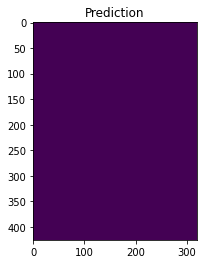

In [13]:
from mmseg.apis import inference_segmentor, init_segmentor, show_result_pyplot
import mmcv
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import numpy as np
import os
import glob
import zipfile

PATH_TO_TEST_IMAGES_DIR= data_root+dataset+"/img_dir/val"
PATH_TO_LABEL_IMAGES_DIR= data_root+dataset+"/ann_dir/val"
TEST_IMAGE_PATHS = glob.glob(os.path.join(PATH_TO_TEST_IMAGES_DIR, "*.jpg"))
LABEL_PATHS= glob.glob(os.path.join(PATH_TO_LABEL_IMAGES_DIR, "*.png"))

TEST_IMAGE_PATHS.sort()
LABEL_PATHS.sort()

checkpoint= root_dir+'/work_dirs/tutorial/iter_19200.pth' #checkpoint path
model = init_segmentor(cfg, checkpoint, device='cuda:0')
palette = [[120, 120, 120], [6, 230, 230]] #dataset palette
print(len(TEST_IMAGE_PATHS))

for i in range(0, len(TEST_IMAGE_PATHS)):
  img = mmcv.imread(TEST_IMAGE_PATHS[i])
  label = mmcv.imread(LABEL_PATHS[i])
  result = inference_segmentor(model, img)
  img_name= LABEL_PATHS[i].split("/")[7] #FOR MASK
  # img_name= TEST_IMAGE_PATHS[i].split("/")[7] #for overlay

  #prediction mask
  arr= np.array(result)
  arr=np.squeeze(arr)

  #overlay image
  # overlay = model.show_result(img, result, palette=palette, show=False)

  # plt.subplot(1, 7 , 1)
  # plt.imshow(img)
  # plt.title("Input image")

  # plt.subplot(1, 7,  3)
  # plt.imshow(label)
  # plt.title("Ground Truth")

  # plt.subplot(1, 7,  5)
  plt.imshow(arr)
  plt.title("Prediction")

  # plt.subplot(1, 7,  7)
  # plt.imshow(mmcv.bgr2rgb(overlay))
  # plt.title("Overlay")

  # show_result_pyplot(model, img, result,palette)

  image_file_name= root_dir+"/work_dirs/results/masks/"+img_name
  plt.savefig(image_file_name)
  print("saving "+img_name)
  i= i+1

# plt.figure(figsize=(8, 6))
# show_result_pyplot(model, img, result,palette)